# IAPS ANALISYS 

In this notebook we analyse the power in predicting IMT from the activation maps during the IAPS task. By means of a nested cross-validation, we assessed the generalization of the model (outer loop) and the optimal value of the regularisation LASSO coefficient (inner loop). All the folds in the outer and inner loop have been generated in a stratified fashion way such that there are not differences between the training and test set in IMT as measured by a Kolmogorv-Smirnov test.

In [291]:
# Here the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as opj
import seaborn as sns
import os
import time
from joblib import Parallel, delayed

from nilearn import masking, image, plotting
from sklearn.model_selection import (StratifiedKFold, cross_validate, cross_val_predict)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ks_2samp, pearsonr, zscore
from sklearn.utils import resample
from glob import glob
import re

from statsmodels.formula import api as smf
from statsmodels.regression import linear_model

In [414]:
# Bayes factor computed according to exact formula (25) in
# Ly,  A.,  Verhagen,  A. J.  &  Wagenmakers,  E.-J.  (2015).  
# Harold  Jeffreys’s  Default  Bayes  FactorHypothesis Tests: Explanation, Extension, and Application in Psychology. 
# Journal of MathematicalPsychology, Available online 28 August 2015, http://dx.doi.org/10.1016/j.jmp.2015.06.004.

from scipy.special import beta, hyp2f1, loggamma

def bayesFactorCorr(r, n, rho = 1/3.):
    
    a = (2 + (n-1)*rho)/(2.*rho)
    b = (2 + (n)*rho)/(2.*rho)
    c = (n-1)/2
    
    numerator = np.log(2**((rho - 2)/rho)*np.sqrt(np.pi)) + loggamma(a)
    
    denominator = np.log(beta(1/rho, 1/rho)) + loggamma(b)
    
    return np.exp(numerator - denominator + np.log(hyp2f1(c, c, b, r**2)))

In [52]:
# The working directory
work_dir = os.path.abspath("../")

In [53]:
# For reproducibility
RANDOM_STATE = 0

In [54]:
meta_data = pd.read_csv(opj(work_dir, "data", "ID_IMT_demographics.csv"))

In [224]:
# Grey mask, amygdala mask and lesion mask
grey_mask = image.load_img(img=opj(work_dir,"data", "reslicedER_grey25grey25.nii"))
grey_mask = image.math_img("img > 0.5", img = grey_mask)

amygdala_mask = image.load_img(img=opj(work_dir, "data", "amygdala_resliced_to_iaps.nii"))
amygdala_mask = image.math_img("img > 0.5", img = amygdala_mask)

lesion_mask = image.math_img("img1 - img2", img1 = grey_mask, img2 = amygdala_mask)

In [186]:
AHAB_subjects = pd.read_csv(opj(work_dir, "data", "AHAB2_ID_IMT.csv"))["LABID"].values
PIP_subjects = meta_data[meta_data['study']=="PIP"]['ID'].values

In [187]:
ahab_imgs = []
ahab_idxs = []
for sub_id in AHAB_subjects:
    try:
        ahab_imgs.append(image.load_img(opj(work_dir, "data", 
                                         "ER_LookNegative_LookNeutral", 
                                         'activation_maps', 
                                         'ER_LNegLNeu_' + str(sub_id) + '.nii')))
        
        ahab_idxs.append(meta_data[meta_data['ID']==sub_id].index[0])
        
    except:
        pass

In [190]:
pip_imgs = []
pip_idxs = []
for sub_id in PIP_subjects:
    try:
        pip_imgs.append(image.load_img(opj(work_dir, "data", 
                                         "ER_LookNegative_LookNeutral", 
                                         'activation_maps', 
                                         'ER_LNegLNeu_' + str(sub_id) + '.nii')))
    
        
        pip_idxs.append(meta_data[meta_data['ID']==sub_id].index[0])
        
    except:
        pass

In [417]:
print("The number of subjects for AHAB-2 is %d and for PIP is %d" % (len(ahab_idxs), len(pip_idxs)))

The number of subjects for AHAB-2 is 179 and for PIP is 159


In [228]:
X_ahab = masking.apply_mask(ahab_imgs, mask_img = grey_mask)
X_pip = masking.apply_mask(pip_imgs, mask_img = grey_mask)

y_ahab = meta_data.loc[ahab_idxs, "IMT"].values
y_pip = meta_data.loc[pip_idxs, "IMT"].values

In [229]:
y_ahab_discrete = np.digitize(y_ahab, np.quantile(y_ahab, q=[0.2, 0.4, 0.6, 0.8]))
y_pip_discrete = np.digitize(y_pip, np.quantile(y_ahab, q=[0.2, 0.4, 0.6, 0.8]))

Create and the test loop for optimisitation is balanced

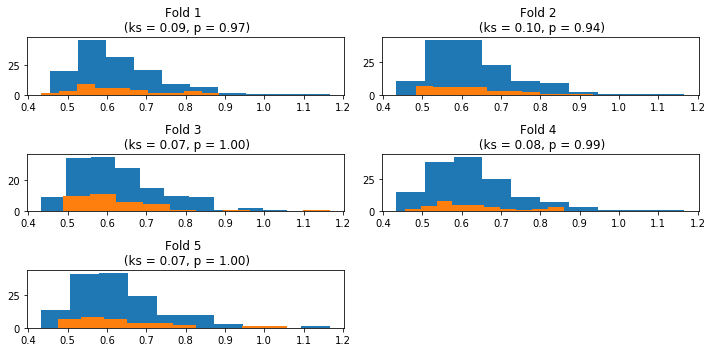

In [197]:
cv_ahab = StratifiedKFold(n_splits=5,  
                          shuffle = True, 
                          random_state=RANDOM_STATE).split(np.zeros(len(y_ahab_discrete)), y_ahab_discrete)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, val_index) in enumerate(cv_ahab):
    
    y_train, y_val = y_ahab[train_index], y_ahab[val_index]
    
    axs[ii].hist(y_train, label="training")
    axs[ii].hist(y_val, label="validation")
    
    ks, p = ks_2samp(y_train, y_val)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

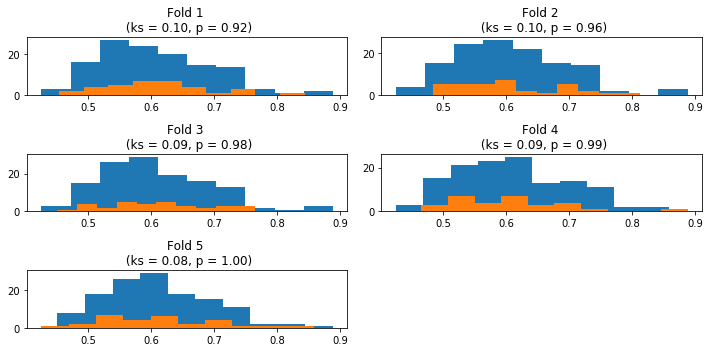

In [198]:
cv_pip = StratifiedKFold(n_splits=5,  
                         shuffle = True, 
                         random_state=RANDOM_STATE).split(np.zeros(len(y_pip_discrete)), y_pip_discrete)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, val_index) in enumerate(cv_pip):
    
    y_train, y_val = y_pip[train_index], y_pip[val_index]
    
    axs[ii].hist(y_train, label= "training")
    axs[ii].hist(y_val, label = "validation")
    
    ks, p = ks_2samp(y_train, y_val)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

In [418]:
def fit_lasso(X_train, X_val, y_train, y_val, alpha):

    clf = Lasso(alpha=alpha, max_iter=1e5, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    
    return mean_squared_error(y_val, clf.predict(X_val))


def estim_opt(X, y, y_discrete):

    cv_inner = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE)

    # This will generate a grid of alphas to optimise the model
    alphas = 10**np.linspace(-5,1, 100) #_alpha_grid(X, y, n_alphas = 100)

    XX_trains, XX_vals = [], []
    yy_trains, yy_vals = [], []
    
    for train_index, val_index in cv_inner.split(np.zeros(len(y)), y_discrete):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        ss = StandardScaler(with_std=False)
        pca = PCA()

        X_train_transform = pca.fit_transform(ss.fit_transform(X_train))
        X_val_transform = pca.transform(ss.transform(X_val))

        XX_trains.append(X_train_transform)
        XX_vals.append(X_val_transform)
        yy_trains.append(y_train)
        yy_vals.append(y_val)

    res_loops = []
    for X_train, X_val, y_train, y_val in zip(XX_trains, XX_vals, yy_trains, yy_vals):

        res_loops.append(Parallel(n_jobs=10)(delayed(fit_lasso)(X_train, X_val, y_train, y_val, alpha) for alpha in alphas))

    res_loops = np.array(res_loops)

    opt_alpha = alphas[np.argmin(res_loops.mean(axis=0))]

    #refit all data with this optimal alpha
    pip =  make_pipeline(StandardScaler(with_std=False), PCA(), 
                         Lasso(alpha=opt_alpha, max_iter=1e5, random_state=RANDOM_STATE))

    pip.fit(X, y)
    return pip

In [419]:
y_pred, y_true = [], []

model_ahab = estim_opt(X_ahab, y_ahab, y_ahab_discrete)

y_pred.append(model_ahab.predict(X_pip))
y_true.append(y_pip)

model_pip = estim_opt(X_pip, y_pip, y_pip_discrete)

y_pred.append(model_pip.predict(X_ahab))
y_true.append(y_ahab)

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [420]:
r, p = pearsonr(y_true, y_pred)
r

0.2151526607949079

In [421]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred), size=len(y_pred))
    
    corr_boot.append(np.corrcoef(y_pred[boot_idxs],
                                 y_true[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

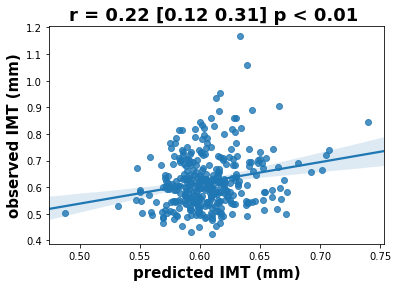

In [422]:
sns.regplot(y_pred, y_true)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [423]:
print(" The Bayes factor is = %.3f" % bayesFactorCorr(r = np.corrcoef(y_true, y_pred)[0,1],
                                                     n=len(y_pred)))

 The Bayes factor is = 317.336


In [446]:
observed_model = estim_opt(X, y, y_discrete)

weight_map = np.matmul(observed_model.named_steps['pca'].components_.T, 
                       observed_model.named_steps['lasso'].coef_)

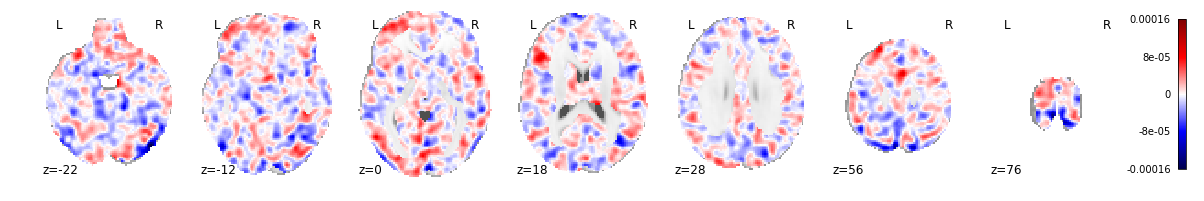

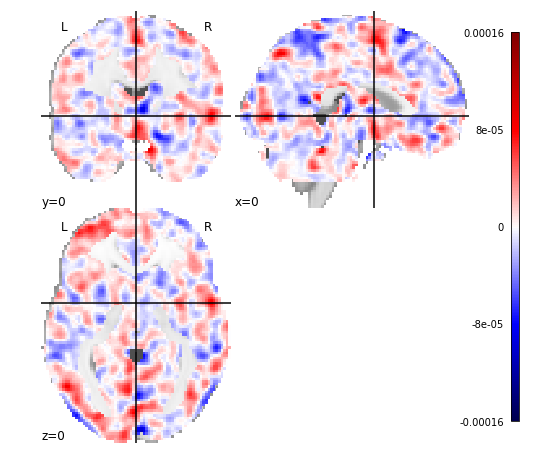

In [447]:
plotting.plot_stat_map(masking.unmask(weight_map, mask_img=grey_mask), 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(masking.unmask(weight_map, mask_img=grey_mask), 
                       threshold=0., display_mode='tiled', cut_coords=(0,0,0), cmap=plt.cm.seismic)

## Confidence intervals by percentile bootstrap

In [24]:
n_boot = 1000

t_0 = time.time()

weight_map_boots = []

random_seed = 0
ii = 0
while ii < n_boot:
    try:
        X_boot, y_boot, y_discrete_boot = resample(X, y, y_discrete, 
                                                   stratify = study_labels,
                                                   random_state = random_seed)


        model_boot = estim_opt(X_boot, y_boot, y_discrete_boot)

        weight_map_boots.append(np.matmul(model_boot.named_steps['pca'].components_.T, 
                                          model_boot.named_steps['lasso'].coef_))

        if ii % 100 == 0:
            print("bootstrap iteration %d finished " % ii)
        ii += 1
        random_seed += 1          
    except:
        random_seed += 1 
        pass

t_f = time.time()
weight_map_boots = np.array(weight_map_boots)

bootstrap iteration 0 finished 
bootstrap iteration 100 finished 
bootstrap iteration 200 finished 
bootstrap iteration 300 finished 
bootstrap iteration 400 finished 
bootstrap iteration 500 finished 
bootstrap iteration 600 finished 
bootstrap iteration 700 finished 
bootstrap iteration 800 finished 
bootstrap iteration 900 finished 


In [29]:
np.savez_compressed("resuts_iaps.npz", weight_map = weight_map, weight_map_boots = weight_map_boots)

In [30]:
alpha = 0.05

low_ci = np.quantile(weight_map_boots, q = alpha/(2), axis=0)
high_ci = np.quantile(weight_map_boots, q=1-alpha/(2), axis=0)

In [32]:
mask_sig = low_ci*high_ci > 0
print("the number of significant voxels = %d" % sum(mask_sig))

the number of significant voxels = 24338


In [36]:
weight_map_thr = masking.unmask(np.multiply(mask_sig, weight_map), mask_img=mask_img)

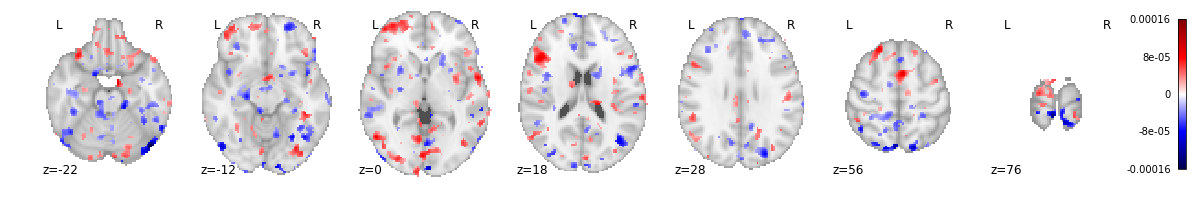

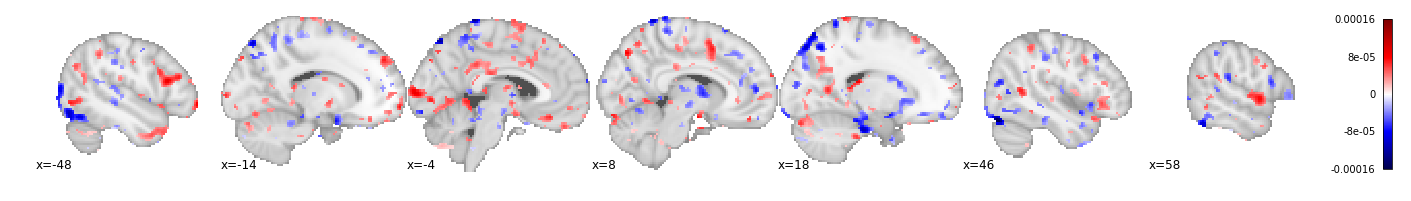

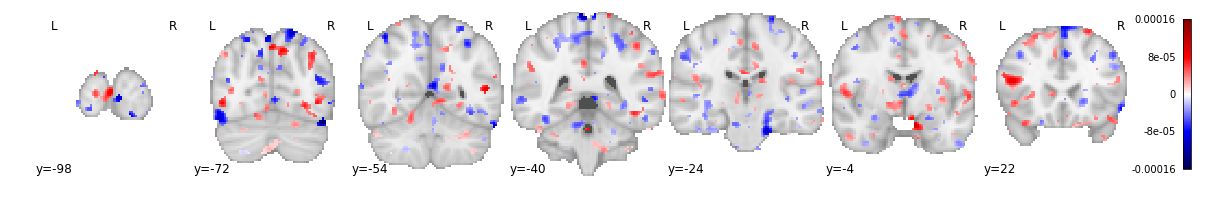

In [37]:
plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic)
pass

In [39]:
from nilearn.regions import connected_regions
voxel_size = 2 
k_voxels = 50

regions_extracted_img_pos, _ = connected_regions(masking.unmask(np.multiply(mask_sig, weight_map), 
                                                                mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

regions_extracted_img_neg, _ = connected_regions(masking.unmask(-1*np.multiply(mask_sig, weight_map), 
                                                                mask_img = mask_img), 
                                             min_region_size=k_voxels*voxel_size**3)

In [40]:
new_data = np.zeros(mask_img.shape)

for img in image.iter_img(regions_extracted_img_pos):
    new_data += img.get_data().copy()

for img in image.iter_img(regions_extracted_img_neg):
    new_data -= img.get_data().copy()
    
img_vox_thr = image.new_img_like(mask_img, new_data)

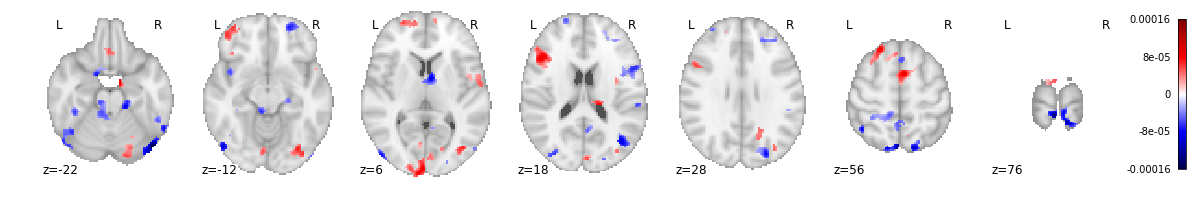

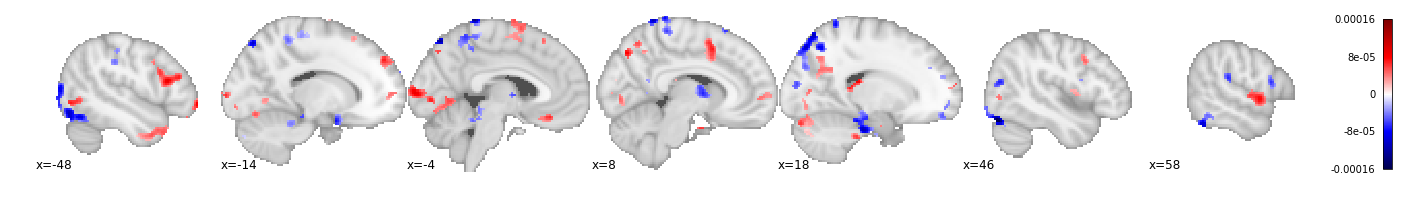

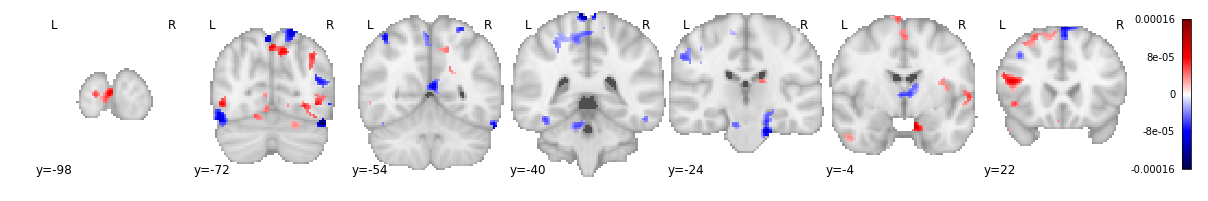

In [41]:
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic)
pass

In [45]:
print(" Number of voxels with p < 0.05 and k = 50 = %d " % sum(abs(img_vox_thr.get_data().flatten())>0))

 Number of voxels with p < 0.05 and k = 50 = 10230 


## ANCILLARY RESULTS

### Amygdala mask

In [424]:
X_amygdala_ahab = masking.apply_mask(ahab_imgs, mask_img = amygdala_mask, ensure_finite = True)
X_amygdala_pip = masking.apply_mask(pip_imgs, mask_img = amygdala_mask, ensure_finite = True)

In [425]:
y_pred_amygdala, y_true_amygdala = [], []

model_ahab = estim_opt(X_amygdala_ahab, y_ahab, y_ahab_discrete)

y_pred_amygdala.append(model_ahab.predict(X_amygdala_pip))
y_true_amygdala.append(y_pip)

model_pip = estim_opt(X_amygdala_pip, y_pip, y_pip_discrete)

y_pred_amygdala.append(model_pip.predict(X_amygdala_ahab))
y_true_amygdala.append(y_ahab)

y_pred_amygdala = np.concatenate(y_pred_amygdala)
y_true_amygdala = np.concatenate(y_true_amygdala)

In [426]:
r, p = pearsonr(y_true_amygdala, y_pred_amygdala)
r

-0.08060678844411501

In [427]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred_amygdala), size=len(y_pred_amygdala))
    
    corr_boot.append(np.corrcoef(y_pred_amygdala[boot_idxs],
                                 y_true_amygdala[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

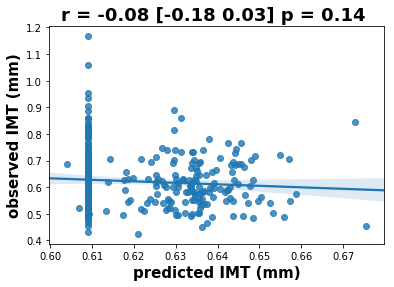

In [428]:
sns.regplot(y_pred_amygdala, y_true_amygdala)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [429]:
print(" The Bayes factor is = %.3f" % bayesFactorCorr(r = np.corrcoef(y_true_amygdala, y_pred_amygdala)[0,1],
                                                     n=len(y_pred_amygdala)))

 The Bayes factor is = 0.372


### Predictions without the amygdala

In [430]:
X_lesion_ahab = masking.apply_mask(ahab_imgs, mask_img = lesion_mask, ensure_finite = True)
X_lesion_pip = masking.apply_mask(pip_imgs, mask_img = lesion_mask, ensure_finite = True)

In [431]:
y_pred_lesion, y_true_lesion = [], []

model_ahab = estim_opt(X_lesion_ahab, y_ahab, y_ahab_discrete)

y_pred_lesion.append(model_ahab.predict(X_lesion_pip))
y_true_lesion.append(y_pip)

model_pip = estim_opt(X_lesion_pip, y_pip, y_pip_discrete)

y_pred_lesion.append(model_pip.predict(X_lesion_ahab))
y_true_lesion.append(y_ahab)

y_pred_lesion = np.concatenate(y_pred_lesion)
y_true_lesion = np.concatenate(y_true_lesion)

In [432]:
r, p = pearsonr(y_true_lesion, y_pred_lesion)
r

0.2088749317055227

In [433]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred_lesion), size=len(y_pred_lesion))
    
    corr_boot.append(np.corrcoef(y_pred_lesion[boot_idxs],
                                 y_true_lesion[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

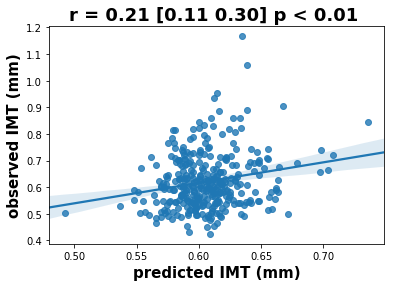

In [434]:
sns.regplot(y_pred_lesion, y_true_lesion)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [435]:
print(" The Bayes factor is = %.3f" % bayesFactorCorr(r = np.corrcoef(y_true_lesion, y_pred_lesion)[0,1],
                                                     n=len(y_pred_amygdala)))

 The Bayes factor is = 200.312


Addig age, sex and CMR as regressors between predicted and observed values

In [436]:
ss = StandardScaler()

In [437]:
z_stouffer = np.nanmean(np.concatenate((ss.fit_transform(meta_data.loc[:, ["waist"]]), 
                                            ss.fit_transform(-1*meta_data.loc[:, ["HDL"]]),  
                                            ss.fit_transform(meta_data.loc[:, ["triglycerides"]]), 
                                            ss.fit_transform(meta_data.loc[:, ["glucose"]]), 
                                            ss.fit_transform(meta_data.loc[:, ["SBP"]])), axis=1), 
                            axis=1)


In [438]:
# Build ancillary data frame with observed and predicted values, age, sex and cmr
ancillary_df = pd.DataFrame({'y_true' : y_true, 
                             'y_pred': y_pred, 
                             'age': meta_data.loc[pip_idxs + ahab_idxs, "age"].values,
                             'sex': meta_data.loc[pip_idxs + ahab_idxs, "sex"].values,
                             'cmr': z_stouffer[pip_idxs + ahab_idxs],
                            })

ancillary_df.head()

,y_true,y_pred,age,sex,cmr
0,0.547937,0.579505,34,2,-0.751240
1,0.626437,0.589842,32,2,-0.775198
2,0.611375,0.631539,33,1,-0.141250
3,0.644250,0.611286,48,1,0.318245
4,0.589000,0.549917,39,1,0.685835


In [439]:
#standarise continuous variables 
ancillary_df.loc[:, ['y_true', 'y_pred', 'age', 'cmr']] = ancillary_df.loc[:, ['y_true', 'y_pred', 'age', 'cmr']].apply(zscore)

In [440]:
print("Observed IMT vs CMR RSquared = {:.3f}".format(smf.ols('y_true ~ cmr', 
                                                            data=ancillary_df).fit().rsquared))
print("Observed IMT vs CMR + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + y_pred', 
                                                                            data=ancillary_df).fit().rsquared))

Observed IMT vs CMR RSquared = 0.134
Observed IMT vs CMR + Predicted IMT RSquared = 0.191


In [441]:
print("Observed IMT vs CMR + Age + Sex RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex)', 
                                                            data=ancillary_df).fit().rsquared))
print("Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex) + y_pred', 
                                                                        data=ancillary_df).fit().rsquared))

Observed IMT vs CMR + Age + Sex RSquared = 0.337
Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = 0.379


In [442]:
smf.ols('y_true ~ C(sex)*y_pred', data=ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     7.524
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           6.93e-05
Time:                        18:18:24   Log-Likelihood:                -468.55
No. Observations:                 338   AIC:                             945.1
Df Residuals:                     334   BIC:                             960.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1221      0.074      1.646      0.101      -0.024       0.268
C(sex)[T.2]           -0.2430      0.106     -2.288      0.023      -0.452      -0.034
y_pred                 0.2676      0.072      3.715      0.000       0.126       0.409
C(sex)[T.2]:y_pred    -0.0952      0.107     -0.893      0.372      -0.305       0.114
==============================================================================
Omnibus:                       80.705   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.617
Skew:                           1.176   Prob(JB):                     3.00e-41
Kurtosis:                       5.778   Cond. No.                         2.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [443]:
smf.ols('y_true ~ age*y_pred', data = ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     45.47
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           1.15e-24
Time:                        18:18:27   Log-Likelihood:                -421.72
No. Observations:                 338   AIC:                             851.4
Df Residuals:                     334   BIC:                             866.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0055      0.046     -0.118      0.906      -0.096       0.085
age            0.4876      0.046     10.547      0.000       0.397       0.579
y_pred         0.1852      0.046      3.997      0.000       0.094       0.276
age:y_pred     0.0759      0.045      1.675      0.095      -0.013       0.165
==============================================================================
Omnibus:                       65.266   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.729
Skew:                           0.975   Prob(JB):                     6.16e-32
Kurtosis:                       5.530   Cond. No.                         1.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [444]:
smf.ols('y_true ~ cmr*y_pred', data=ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     28.22
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           2.75e-16
Time:                        18:18:29   Log-Likelihood:                -441.42
No. Observations:                 338   AIC:                             890.8
Df Residuals:                     334   BIC:                             906.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0080      0.049      0.162      0.871      -0.088       0.104
cmr            0.3823      0.049      7.807      0.000       0.286       0.479
y_pred         0.2690      0.051      5.284      0.000       0.169       0.369
cmr:y_pred     0.1269      0.059      2.147      0.032       0.011       0.243
==============================================================================
Omnibus:                       38.134   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.310
Skew:                           0.787   Prob(JB):                     7.22e-12
Kurtosis:                       4.078   Cond. No.                         1.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [445]:
r, p = pearsonr(ancillary_df.loc[ancillary_df.cmr < ancillary_df.cmr.median(), "y_true"],
                ancillary_df.loc[ancillary_df.cmr < ancillary_df.cmr.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for under median CMR r = {:.3f} (p = {:.3f})".format(r, p))

r, p = pearsonr(ancillary_df.loc[ancillary_df.cmr > ancillary_df.cmr.median(), "y_true"],
                ancillary_df.loc[ancillary_df.cmr > ancillary_df.cmr.median(), "y_pred"])

print("association Observed IMT vs Predicted IMT for over median CMR r = {:.3f} (p = {:.3f})".format(r, p))

association Observed IMT vs Predicted IMT for under median CMR r = 0.291 (p = 0.000)
association Observed IMT vs Predicted IMT for over median CMR r = 0.187 (p = 0.015)
